# $\xi(n_1, n_2, r)$:

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from gal_goku import summary_stats
from gal_goku import plot

## Load the data
plot_xi = plot.PlotXiSims() 
data_dir = '/home/qezlou/HD2/HETDEX/cosmo/data/xi_on_grid/'
xi = summary_stats.Xi(data_dir, fid='HF', logging_level='ERROR')
sim_tag = 'compressed_10p_Box1000_Part3000_0242'
_, _, corrs = xi.get_xi_n1_n2_r()
corrs.shape

(21, 21, 21, 50)

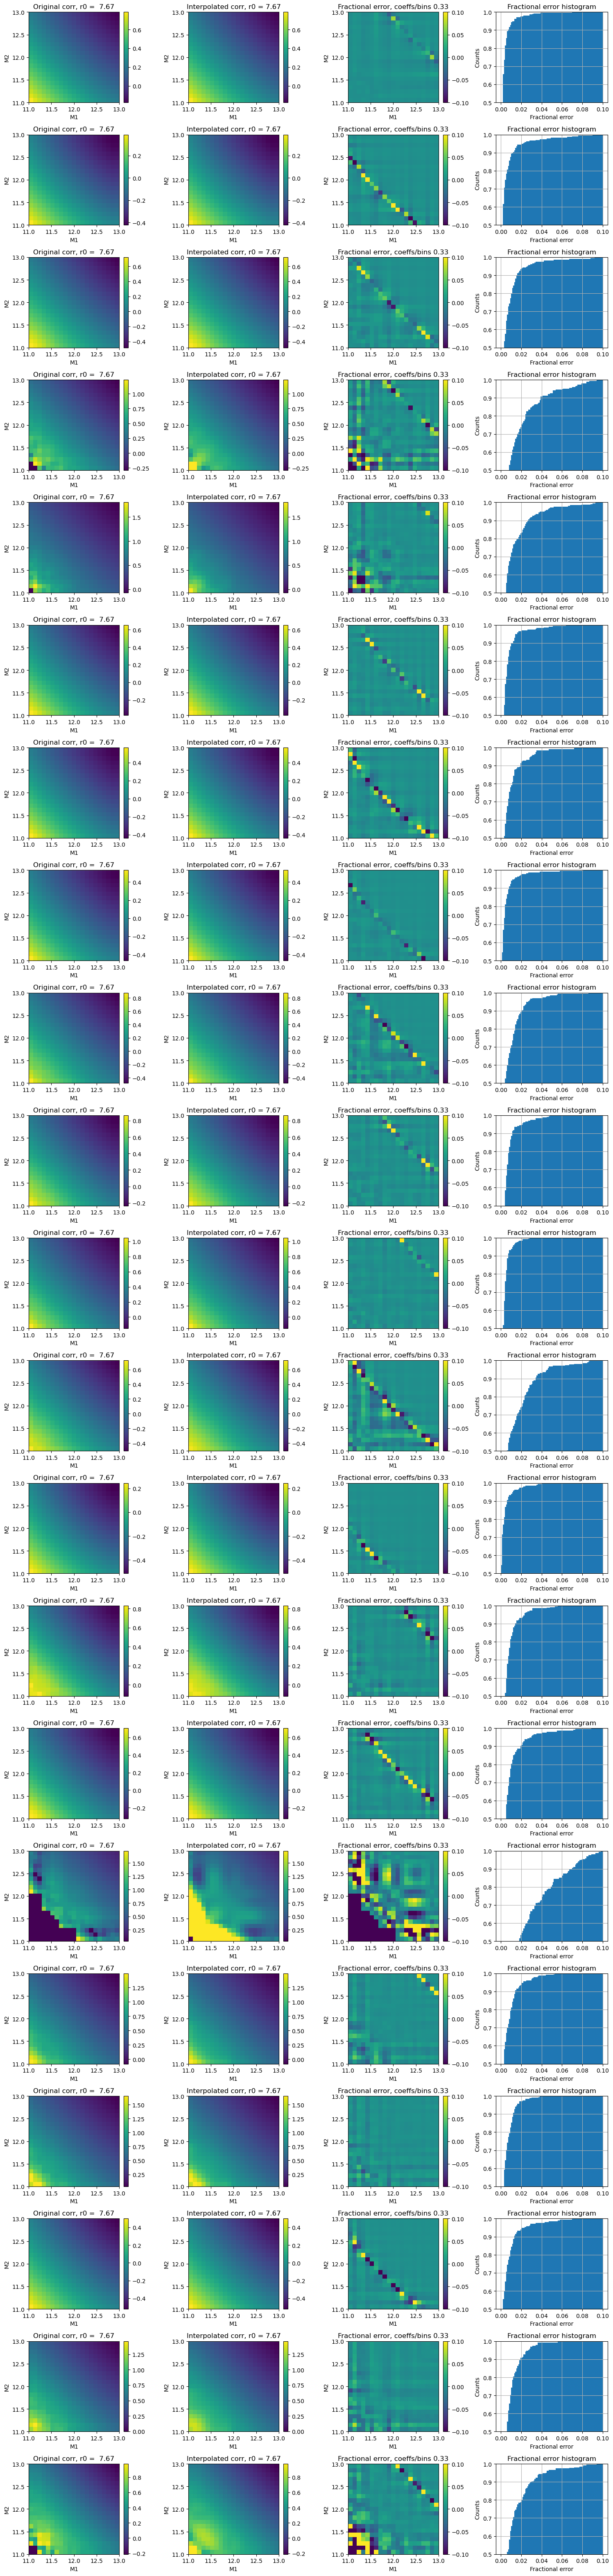

In [5]:
import numpy as np
from matplotlib import pyplot as plt
from gal_goku import summary_stats
from gal_goku import plot

def do_spine_n1_n2(fid='HF', r_ind=22):
    """
    Check the accuracy of the spline interpolation on
    (n1, n2) pairs of the correlation function
    """
    ## Load the data
    plot_xi = plot.PlotXiSims() 
    data_dir = '/home/qezlou/HD2/HETDEX/cosmo/data/xi_on_grid/'
    xi = summary_stats.Xi(data_dir, fid, logging_level='ERROR')
    
    fig, ax = plt.subplots(len(xi.sim_tags), 4, figsize=(15, 3*len(xi.sim_tags)))
    for i, stag in enumerate(xi.sim_tags):
        ## Fit the spline
        r0, mass_bins, corr_2d, spline = xi._do_fit_spline_n1n2(stag, r_ind=r_ind)
        corr_approx = spline(mass_bins, mass_bins)
        # Flip the mass bins to match the original
        corr_approx = np.flip(corr_approx, axis=(0,1))
        corr_2d = np.flip(corr_2d, axis=(0,1))
        mass_bins = mass_bins[::-1]
        # Fractional error
        frac_err = corr_2d/corr_approx -1
        abs_err = np.abs(frac_err[corr_2d >= -10])


        # Plotting
        ## Plot the original and interpolated correlation functions
        extent=[mass_bins[-1], mass_bins[0], mass_bins[-1], mass_bins[0]]
        vmin, vmax = np.nanmin(corr_2d[corr_2d > -8]), np.nanmax(corr_2d[corr_2d > -8])
        im = ax[i, 0].imshow(corr_2d, origin='lower', extent=extent, vmin=vmin, vmax=vmax)
        cbar = fig.colorbar(im, ax=ax[i,0], fraction=0.046, pad=0.04)
        ax[i, 0].set_title(f'Original corr, r0 =  {(r0):.2f}')
        ax[i, 0].set_xlabel('M1')
        ax[i, 0].set_ylabel('M2')
        im = ax[i, 1].imshow(corr_approx, origin='lower', extent=extent, vmin=vmin, vmax=vmax)
        cbar = fig.colorbar(im, ax=ax[i,1], fraction=0.046, pad=0.04)
        ax[i, 1].set_title(f'Interpolated corr, r0 = {(r0):.2f}')
        ax[i, 1].set_xlabel('M1')
        ax[i, 1].set_ylabel('M2')
        ## Plot the delta
        
        im = ax[i, 2].imshow(frac_err, origin='lower', extent=extent, vmin=-0.1, vmax=0.1)
        cbar = fig.colorbar(im, ax=ax[i,2], fraction=0.046, pad=0.04)
        upper_tri_size = np.triu(corr_2d).size
        ax[i, 2].set_title(f'Fractional error, coeffs/bins {(spline.get_coeffs().size/upper_tri_size):.2f}')
        ax[i, 2].set_xlabel('M1')
        ax[i, 2].set_ylabel('M2')
       
        ax[i, 3].hist(abs_err.flatten(), bins=100, range=(0, 0.1), cumulative=True, density=True)
        ax[i,3].set_ylim(0.5, 1)
        ax[i, 3].set_title(f'Fractional error histogram')
        ax[i, 3].set_xlabel('Fractional error')
        ax[i, 3].set_ylabel('Counts')
        ax[i,3].grid()




        
    #fig.suptitle(f'LOO {n_components} PCA components vs original {orig_shape[1]*orig_shape[2]} bins | fid {fid}')
    fig.tight_layout()

do_spine_n1_n2(fid='HF', r_ind=22)



### Err vs (r, n1, n2) across all sims

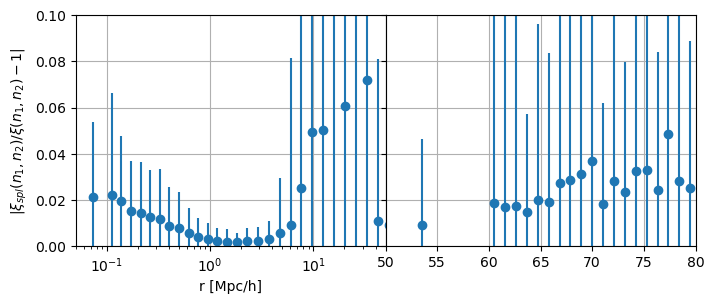

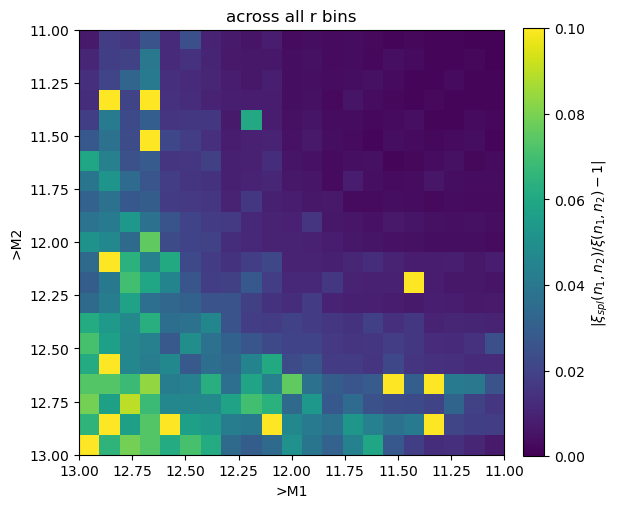

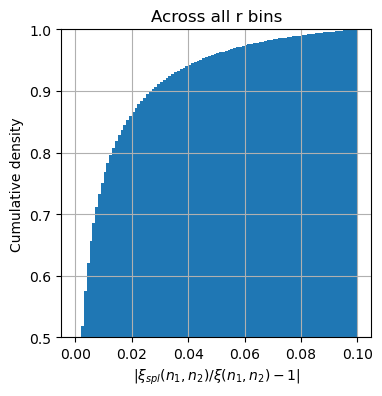

In [37]:
import numpy as np
from matplotlib import pyplot as plt
from gal_goku import summary_stats
from gal_goku import plot

def get_err_spline_n1_n2(fid='HF'):
    """
    Check the accuracy of the spline interpolation on
    (n1, n2) pairs of the correlation function
    """
    ## Load the data
    plot_xi = plot.PlotXiSims() 
    data_dir = '/home/qezlou/HD2/HETDEX/cosmo/data/xi_on_grid/'
    xi = summary_stats.Xi(data_dir, fid, logging_level='ERROR')
    # store all the fractional errors
    abs_errs = np.full((len(xi.sim_tags), xi.mass_bins.size, xi.mass_bins.size, xi.rbins.size), np.nan)
    for r_ind in range(xi.rbins.size):
        for i, stag in enumerate(xi.sim_tags):
            ## Fit the spline
            r0, mass_bins, corr_2d, spline = xi._do_fit_spline_n1n2(stag, r_ind=r_ind)
            corr_approx = spline(mass_bins, mass_bins)
            # Flip the mass bins to match the original
            corr_approx = np.flip(corr_approx, axis=(0,1))
            corr_2d = np.flip(corr_2d, axis=(0,1))
            # Fractional error
            frac_err = corr_2d/corr_approx -1
            # Where the data doesn't exist, set the fractional error to nan
            frac_err[corr_2d <= -9] = np.nan
            abs_errs[i, :, :, r_ind] = np.abs(frac_err)
    return abs_errs, xi.mass_bins, xi.rbins

def plot_err_spline_n1_n2(fid='HF'):
    """
    Plot the mean fractional error of the spline interpolation on
    (n1, n2) pairs of the correlation function. 
    We are not comparing where the data is missing
    """
    fig, ax = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
    fig.subplots_adjust(wspace=0)
    
    abs_errs, mass_bins, rbins = get_err_spline_n1_n2(fid)
    ax[0].errorbar(rbins, np.nanmean(abs_errs, axis=(0,1,2)), yerr=np.nanstd(abs_errs, axis=(0,1,2)), fmt='o', label='Mean fractional error')
    ax[1].errorbar(rbins, np.nanmean(abs_errs, axis=(0,1,2)), yerr=np.nanstd(abs_errs, axis=(0,1,2)), fmt='o', label='Mean fractional error')
    ax[0].set_xlim(0.05, 50)
    ax[0].set_xscale('log')
    ax[0].set_ylim(0, 0.1)
    ax[0].grid()
    ax[0].set_xlabel('r [Mpc/h]')
    ax[0].set_ylabel(r'$| \xi_{spl}(n_1, n_2) / \xi(n_1,n_2) - 1 |$')
    ax[1].set_xlim(50, 80)
    ax[1].set_ylim(0, 0.1)
    ax[1].grid()

    fig,ax = plt.subplots(1, 1, figsize=(6, 6))
    err_n1_n2 = np.nanmean(abs_errs, axis=(0,3))
    if fid == 'HF':
        vmin, vmax = 0, 0.1
    else:
        vmin, vmax = 0, 0.2
    im = ax.imshow(err_n1_n2, origin='lower', extent=[mass_bins[-1], mass_bins[0], mass_bins[-1], mass_bins[0]], vmin=vmin, vmax=vmax)
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    ax.set_ylabel(r'$| \xi_{spl}(n_1, n_2) / \xi(n_1,n_2) - 1 |$')
    ax.set_xlabel('>M1')
    ax.set_ylabel('>M2')
    ax.set_title('across all r bins')
    cbar.set_label(r'$| \xi_{spl}(n_1, n_2) / \xi(n_1,n_2) - 1 |$')

    fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    abs_errs_flat = abs_errs.flatten()
    abs_errs_flat = abs_errs_flat[~np.isnan(abs_errs_flat)]
    ax.hist(abs_errs_flat, bins=100, range=(0, 0.1), cumulative=True, density=True)
    ax.set_ylim(0.5, 1)
    ax.set_title('Across all r bins')
    ax.set_xlabel(r'$| \xi_{spl}(n_1, n_2) / \xi(n_1,n_2) - 1 |$')
    ax.set_ylabel('Cumulative density')
    ax.grid()

plot_err_spline_n1_n2(fid='HF')



For HF: 95 percentile error is ~ 5% fractional error.


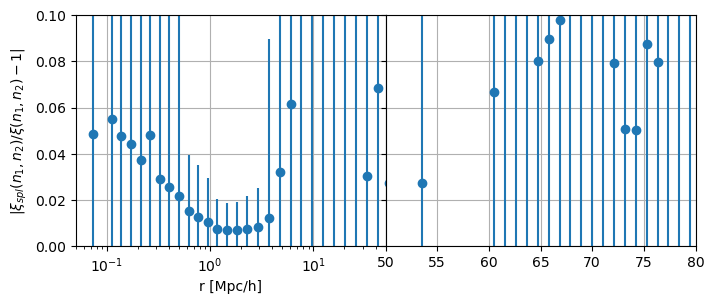

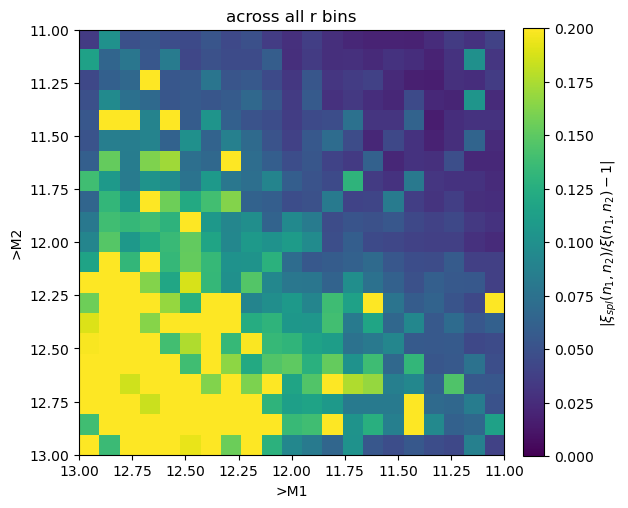

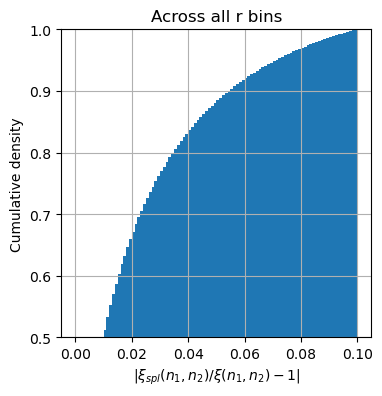

In [38]:
plot_err_spline_n1_n2(fid='L2')

For L2: 95 percentile error is ~ 8% fractional error.


## $\xi(r)$ at fixed $n_1, n_2$:

/home/qezlou/HD2/HETDEX/cosmo/pack_dev/private-gal-emu/src/gal_goku/gal_goku/summary_stats.py:452: RuntimeWarning: invalid value encountered in log10
  corr_sim = np.log10(corr_sim)


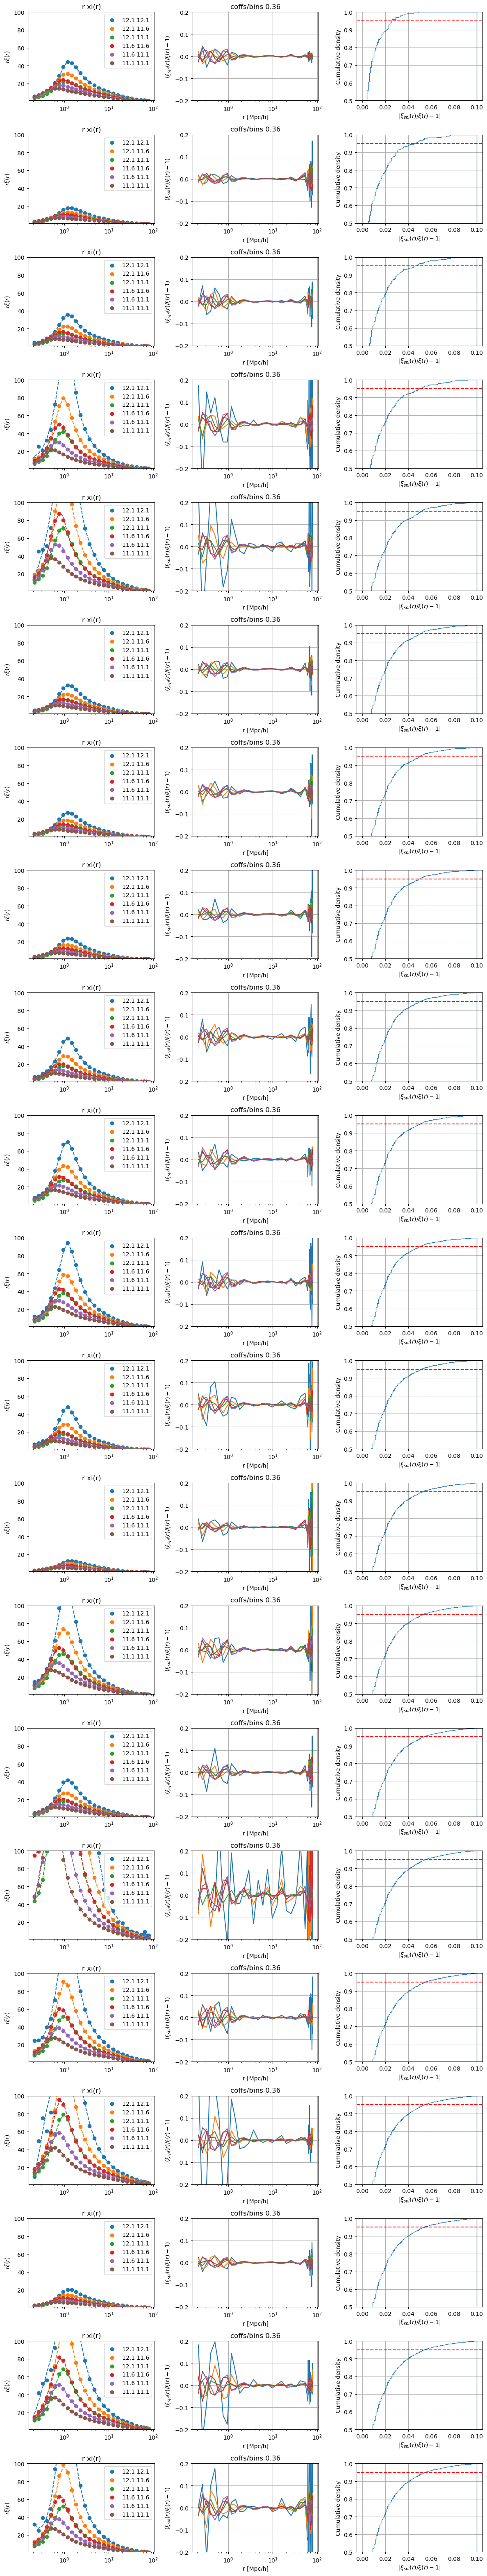

In [83]:
import importlib
import numpy as np
import matplotlib.pyplot as plt
from gal_goku import summary_stats
importlib.reload(summary_stats)

data_dir = '/home/qezlou/HD2/HETDEX/cosmo/data/xi_on_grid/'
xi = summary_stats.Xi(data_dir, fid='HF', logging_level='ERROR')
fig, ax = plt.subplots(len(xi.sim_tags), 3, figsize=(12, 3*len(xi.sim_tags)))
selected_mpairs = np.array([(12.1, 12.1), (12.1, 11.6), (12.1, 11.1), (11.6, 11.6), (11.6, 11.1), (11.1, 11.1)])
selected_mpairs = np.round(selected_mpairs, 2)
all_frac_err = []
for i, stag in enumerate(xi.sim_tags):
    # Fit the splie
    corr, all_splines = xi._sim_fit_spline_r(xi.sim_tags[i])
    corr[corr <= -10] = np.nan
    # interate over selected mass pairs
    for p, mpair in enumerate(selected_mpairs):
        ind = np.where( (xi.mass_pairs[:,0] == mpair[0]) & (xi.mass_pairs[:,1] == mpair[1]))[0][0]
        data = 10**corr[ind].squeeze()
        fit = 10**all_splines[ind](np.log10(xi.rbins))
        coeff_counts = all_splines[ind].c.size
        rbins_counts = xi.rbins.size

        # Plot the r*xi(r)
        ax[i,0].scatter(xi.rbins, xi.rbins* data, label=f'{mpair[0]} {mpair[1]}', color=f'C{p}')
        ax[i,0].plot(xi.rbins, xi.rbins* fit, '--', color=f'C{p}')
        ax[i,0].set_ylim(1, 100)
        ax[i,0].set_xscale('log')
        ax[i,0].legend()
        ax[i,0].set_ylabel(r'$r \xi(r)$')
        ax[i,0].set_title('r xi(r)')

        # Plot the relative error
        frac_err = fit/ data- 1
        ax[i,1].plot(xi.rbins, frac_err, label=stag)
        ax[i,1].set_xscale('log')
        ax[i,1].set_ylim(-0.2, 0.2)
        ax[i,1].grid(True)
        ax[i,1].set_title(f'coffs/bins {coeff_counts/rbins_counts:.2f}')
        ax[i,1].set_ylabel(r'$(\xi_{spl}(r) / \xi(r) - 1)$')
        ax[i,1].set_xlabel('r [Mpc/h]')

        all_frac_err.append(frac_err)
        
    ax[i,2].hist(np.abs(all_frac_err).flatten(), bins=100, range=(0, 0.1), cumulative=True, density=True, histtype='step')
    ax[i,2].axhline(y=0.95, color='r', linestyle='--')
    ax[i,2].set_ylim(0.5, 1)
    ax[i,2].set_xlabel(r'$|\xi_{spl}(r) / \xi(r) - 1|$')
    ax[i,2].set_ylabel('Cumulative density')
    ax[i,2].grid()
fig.tight_layout()

/home/qezlou/HD2/HETDEX/cosmo/pack_dev/private-gal-emu/src/gal_goku/gal_goku/summary_stats.py:460: RuntimeWarning: invalid value encountered in log10
  # And give a weight of zero to these bins while fitting
/tmp/ipykernel_2628692/3589881593.py:26: RuntimeWarning: overflow encountered in power
  fit = 10**all_splines[p](np.log10(xi.rbins))


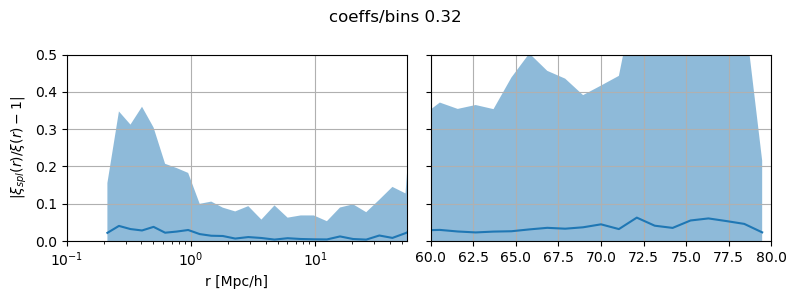

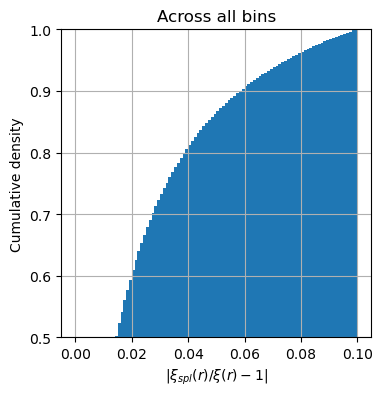

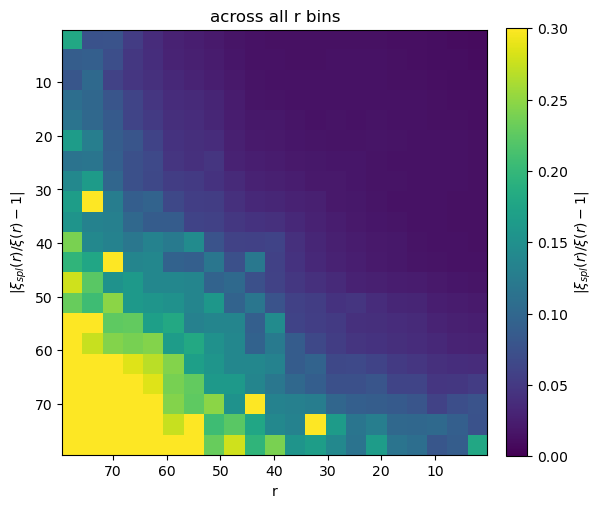

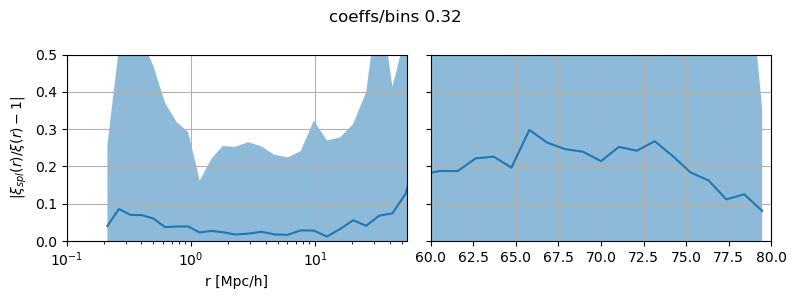

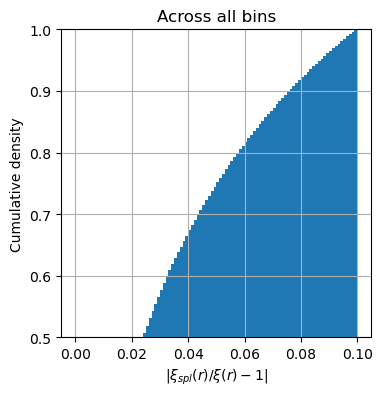

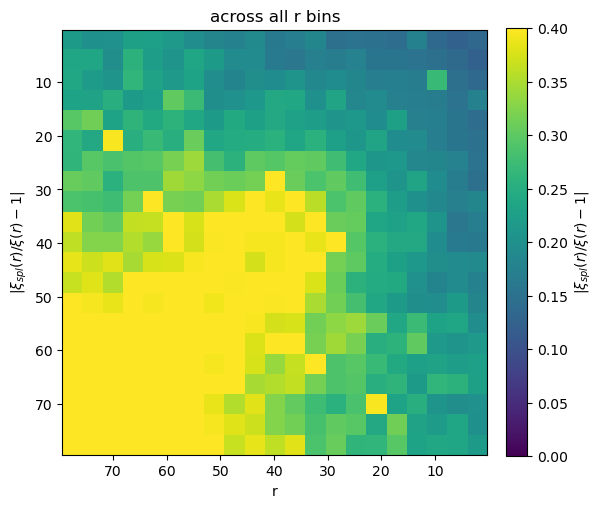

In [129]:
import importlib
import numpy as np
import matplotlib.pyplot as plt
from gal_goku import summary_stats
importlib.reload(summary_stats)

def plot_err_spline_r(fid='HF'):
    """
    Plot the mean fractional error of the spline interpolation on
    r bins for all simulations. 
    """

    data_dir = '/home/qezlou/HD2/HETDEX/cosmo/data/xi_on_grid/'
    xi = summary_stats.Xi(data_dir, fid=fid, logging_level='ERROR')
    corr, all_splines = xi._sim_fit_spline_r(xi.sim_tags[0])
    # This has a shape of (n_sims, n_mass_pairs, n_r_bins)
    all_frac_err = np.full((len(xi.sim_tags), xi.mass_pairs.shape[0], xi.rbins.size), np.nan)
    for i, stag in enumerate(xi.sim_tags):
        # Fit the splie
        corr, all_splines = xi._sim_fit_spline_r(xi.sim_tags[i])
        # Do not include the mssing data
        corr[corr <= -10] = np.nan
        # interate over all mass pairs
        for p, mpair in enumerate(xi.mass_pairs):
            data = 10**corr[p].squeeze()
            fit = 10**all_splines[p](np.log10(xi.rbins))
            coeff_counts = all_splines[p].c.size
            rbins_counts = xi.rbins.size
            # The relative error
            frac_err = fit/ data- 1
            all_frac_err[i, p, :] = np.abs(frac_err)
    fig, ax = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
    fig.subplots_adjust(wspace=0)
    percentiles = np.nanpercentile(all_frac_err, [50, 95], axis=(0,1))
    ax[0].fill_between(xi.rbins, percentiles[1], alpha=0.5)
    ax[0].plot(xi.rbins, percentiles[0], label='Median')
    ax[1].fill_between(xi.rbins, percentiles[1], alpha=0.5)
    ax[1].plot(xi.rbins, percentiles[0], label='Median')
    ax[0].set_xlim(0.1, 55)
    ax[0].set_xscale('log')
    ax[0].set_ylim(0, 0.1)
    ax[0].grid()
    ax[0].set_xlabel('r [Mpc/h]')
    ax[0].set_ylabel(r'$| \xi_{spl}(r) / \xi(r) - 1 |$')
    ax[1].set_xlim(60, 80)
    ax[1].set_ylim(0, 0.5)
    ax[1].grid()
    fig.suptitle(f'coeffs/bins {(coeff_counts/rbins_counts):.2f}')
    fig.tight_layout()

    # Cumulative error of all (n1, n2, r) bins
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    abs_errs_flat = all_frac_err.flatten()
    abs_errs_flat = abs_errs_flat[~np.isnan(abs_errs_flat)]
    ax.hist(abs_errs_flat, bins=100, range=(0, 0.1), cumulative=True, density=True)
    ax.set_ylim(0.5, 1)
    ax.set_title('Across all bins')
    ax.set_xlabel(r'$| \xi_{spl}(r) / \xi(r) - 1 |$')
    ax.set_ylabel('Cumulative density')
    ax.grid()


    # Error on (n, n2) plane
    all_frac_err = xi.make_3d_corr(np.nanmean(all_frac_err, axis=0), symmetric=True)
    all_frac_err = np.nanmean(all_frac_err, axis=-1)
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    if fid == 'HF':
        vmin, vmax = 0, 0.3
    else:
        vmin, vmax = 0, 0.4
    im = ax.imshow(all_frac_err, origin='lower', extent=[xi.rbins[-1], xi.rbins[0], xi.rbins[-1], xi.rbins[0]], vmin=vmin, vmax=vmax)
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    ax.set_ylabel(r'$| \xi_{spl}(r) / \xi(r) - 1 |$')
    ax.set_xlabel('r')
    ax.set_title('across all r bins')
    cbar.set_label(r'$| \xi_{spl}(r) / \xi(r) - 1 |$')



plot_err_spline_r(fid='HF')
plot_err_spline_r(fid='L2')

For HF, we can get to < 5% accuracy for r < 60. For L2 there is just more scatter sim to sim.

## PCA on coeffs: